In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook, trange
pd.pandas.set_option('display.max_columns', None)

import Validation

C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_excel('Train_dataset.xlsx', sheet_name = 'Train_dataset')
test = pd.read_excel('Test_dataset.xlsx', sheet_name = 'Test_dataset')
train.shape, test.shape

((10714, 28), (14498, 27))

In [3]:
data = pd.read_csv('Final_FE_data.csv')
data.shape

(25212, 1017)

In [13]:
sns.distplot(train['Infect_Prob']/100)

In [14]:
y = train['Infect_Prob']/100

In [15]:
y.describe()

count    10714.000000
mean         0.522807
std          0.106747
min          0.292896
25%          0.472774
50%          0.490084
75%          0.527623
max          0.976320
Name: Infect_Prob, dtype: float64

In [18]:
target = pd.Series(np.where(y>0.5, 1, 0))
target.value_counts()

0    6569
1    4145
dtype: int64

In [19]:
target.value_counts(normalize=True)

0    0.613123
1    0.386877
dtype: float64

In [20]:
final_train = data[:train.shape[0]]
final_test = data[train.shape[0]:].reset_index(drop=True)
final_train.shape, final_test.shape

((10714, 1017), (14498, 1017))

In [21]:
final_train.head()

Region  Gender  Name  Married  Children  Occupation  Mode_transport  \
0       0       0     0        0       1.0           0               0   
1       0       0     1        0       2.0           0               1   
2       0       0     2        1       1.0           1               0   
3       0       0     3        0       1.0           2               2   
4       0       0     4        1       2.0           3               2   

   cases/1M  Deaths/1M  comorbidity  Age  Coma score  Pulmonary score  \
0         2          0            0   68           8                0   
1         2          0            1   64          15                1   
2         2          0            2   19          13                2   
3         2          0            3   33           9                3   
4         2          0            1   23           7                0   

   cardiological pressure    Diuresis  Platelets    HBB  d-dimer  Heart rate  \
0                       0  441.000000      154.0   93.0    233.0        82.0   
1                       1  279.901984      121.0   56.0    328.0        89.0   
2                       2  416.000000      124.0  137.0    213.0        77.0   
3                       3  410.000000       98.0  167.0    275.0        64.0   
4                       0  390.000000       21.0  153.0    331.0        71.0   

   HDL cholesterol  Charlson Index  Blood Glucose  Insurance   salary  \
0             58.0              27              7  3600000.0  1300000   
1             68.0               5              6  1600000.0   400000   
2             43.0              40              6  3400000.0   900000   
3             60.0              27              7   700000.0  2300000   
4             64.0              32              7  3200000.0  1100000   

   FT/month  Occupation_na  Children_na  Diuresis_na  Platelets_na  \
0       2.0              0            0            0             0   
1       1.0              0            0            1             0   
2       1.0              0            0            0             0   
3       1.0              0            0            0             0   
4       1.0              0            0            0             0   

   d-dimer_na  Heart_rate_na  Insurance_na  FT_na  Age_bins  \
0           0              0             0      0         5   
1           0              0             0      0         5   
2           0              0             0      0         1   
3           0              0             0      0         2   
4           0              0             0      0         1   

   dist_Children_from_5_nearest_neighbors  \
0                                     0.0   
1                                     0.8   
2                                     0.2   
3                                     0.0   
4                                     0.4   

   Children_divided_by_5_nearest_neighbors  Children_5_nearest_neighbors  \
0                                 1.000000                           1.0   
1                                 1.666667                           1.2   
2                                 1.250000                           0.8   
3                                 1.000000                           1.0   
4                                 1.250000                           1.6   

   dist_Children_from_10_nearest_neighbors  \
0                                      0.2   
1                                      0.8   
2                                     -0.1   
3                                     -0.2   
4                                      0.7   

   Children_divided_by_10_nearest_neighbors  Children_10_nearest_neighbors  \
0                                  1.250000                            0.8   
1                                  1.666667                            1.2   
2                                  0.909091                            1.1   
3                                  0.833333                            1.2   
4   

In [22]:
X = final_train
y = target
test_X = final_test
X.shape, test_X.shape

((10714, 1017), (14498, 1017))

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

In [28]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

err_rf_ac = []
err_rf_f1 = []
err_rf_auc = []

y_pred_tot_rf = []
y_pred_tot_rf_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0

for train_index, test_index in fold.split(X):
    f += 1
    print('*'*30+'Fold '+str(f)+'*'*30)
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(random_state=1999, n_estimators=100)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("AUC Score:", err_auc)
    
    test_pred = rf.predict(test_X)
    test_pred_proba = rf.predict_proba(test_X)[:,1]
    
    err_rf_ac.append(err_ac)
    err_rf_f1.append(err_f1)
    err_rf_auc.append(err_auc)
    
    y_pred_tot_rf.append(test_pred)
    y_pred_tot_rf_prob.append(test_pred_proba)
    

******************************Fold 1******************************
Accuracy: 0.8996733551096594
F1 Score: 0.9002219631814452
AUC Score: 0.9625283205890682
******************************Fold 2******************************
Accuracy: 0.8968735417638825
F1 Score: 0.897596906068313
AUC Score: 0.9655284620199566
******************************Fold 3******************************
Accuracy: 0.8852076528231452
F1 Score: 0.8859786254787195
AUC Score: 0.9602525529972024
******************************Fold 4******************************
Accuracy: 0.9001399906672889
F1 Score: 0.9012035500802658
AUC Score: 0.963136837605249
******************************Fold 5******************************
Accuracy: 0.892623716153128
F1 Score: 0.8935626839699583
AUC Score: 0.9615161672654543


In [29]:
print(np.mean(err_rf_ac))
print(np.mean(err_rf_f1))
print(np.mean(err_rf_auc))

0.8949036513034209
0.8957127457557403
0.9625924680953861


In [30]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [31]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

err_lgb_ac = []
err_lgb_f1 = []
err_lgb_auc = []

y_pred_tot_lgb = []
y_pred_tot_lgb_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m=LGBMClassifier(n_estimators=1000,random_state=1994,learning_rate=0.03,colsample_bytree=0.2,objective='binary',
                     scale_pos_weight=1)
    m.fit(X_train,y_train,eval_set=[(X_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=200)
    
    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(test_X)
    test_pred_proba = m.predict_proba(test_X)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("AUC Score:", err_auc)
    print('\n')
    
    err_lgb_ac.append(err_ac)
    err_lgb_f1.append(err_f1)
    err_lgb_auc.append(err_auc)
    
    y_pred_tot_lgb.append(test_pred)
    y_pred_tot_lgb_prob.append(test_pred_proba)
    

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.969135	valid_0's binary_logloss: 0.203813
Early stopping, best iteration is:
[150]	valid_0's auc: 0.969559	valid_0's binary_logloss: 0.206658
Fold: 1
Accuracy: 0.9076061595893608
F1 Score: 0.9082293864774795
AUC Score: 0.9695589975963809


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.971778	valid_0's binary_logloss: 0.196295
[400]	valid_0's auc: 0.972104	valid_0's binary_logloss: 0.192203
Early stopping, best iteration is:
[276]	valid_0's auc: 0.972366	valid_0's binary_logloss: 0.193367
Fold: 2
Accuracy: 0.9090060662622492
F1 Score: 0.9098498355172696
AUC Score: 0.9723655141941897


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.967618	valid_0's binary_logloss: 0.211282
[400]	valid_0's auc: 0.966845	valid_0's binary_logloss: 0.209716
Early stopping, best iteration is:
[245]	valid_0's auc: 0.967696	valid_0's binary_logloss: 0.

In [32]:
print(np.mean(err_lgb_ac))
print(np.mean(err_lgb_f1))
print(np.mean(err_lgb_auc))

0.9073172463883672
0.9081268945497698
0.9687937920133146


In [35]:
from lightgbm import plot_importance
plot_importance(m, max_num_features=25)

In [37]:
categorical_features_indices = np.where(X.dtypes == 'object')[0]
categorical_features_indices

array([], dtype=int64)

In [38]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
# from catoost import catClassifier
from catboost import CatBoostClassifier

err_cat_ac = []
err_cat_f1 = []
err_cat_auc = []

y_pred_tot_cat = []
y_pred_tot_cat_prob = []


fold = KFold(n_splits=10, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier( 
                         eval_metric='AUC', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=50)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50, cat_features=categorical_features_indices)
    y_pred = cat.predict(X_test)
    y_pred_prob = cat.predict_proba(X_test)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("AUC Score:", err_auc)
    print('\n')
    
    test_pred = cat.predict(test_X)
    test_pred_proba = cat.predict_proba(test_X)[:,1]
    
    err_cat_ac.append(err_ac)
    err_cat_f1.append(err_f1)
    err_cat_auc.append(err_auc)
    
    y_pred_tot_cat.append(test_pred)
    y_pred_tot_cat_prob.append(test_pred_proba)
    

Fold: 1
Accuracy: 0.9039179104477612
F1 Score: 0.9047309757846259
AUC Score: 0.966181613332748


Fold: 2
Accuracy: 0.9095149253731343
F1 Score: 0.909787144315636
AUC Score: 0.9676043962375581


Fold: 3
Accuracy: 0.9113805970149254
F1 Score: 0.9119765586178696
AUC Score: 0.9703368856277661


Fold: 4
Accuracy: 0.9020522388059702
F1 Score: 0.9028728282717027
AUC Score: 0.9670089041325454


Fold: 5
Accuracy: 0.8860877684407096
F1 Score: 0.8868943365290923
AUC Score: 0.9581399726338804


Fold: 6
Accuracy: 0.9103641456582633
F1 Score: 0.9109630564771083
AUC Score: 0.9709833521238121


Fold: 7
Accuracy: 0.9197012138188608
F1 Score: 0.9202659762138244
AUC Score: 0.9703759607846012


Fold: 8
Accuracy: 0.9047619047619048
F1 Score: 0.9060984816710007
AUC Score: 0.9628858867054828


Fold: 9
Accuracy: 0.9010270774976658
F1 Score: 0.9022457157278462
AUC Score: 0.9655137472134027


Fold: 10
Accuracy: 0.8991596638655462
F1 Score: 0.8997757565787278
AUC Score: 0.9669970862556189




In [39]:
print(np.mean(err_cat_ac))
print(np.mean(err_cat_f1))
print(np.mean(err_cat_auc))

0.904796744568474
0.9055610830187435
0.9666027805047415


In [41]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [47]:
err=[]
y_pred_tot=[]
from sklearn.model_selection import KFold,StratifiedKFold
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=LGBMClassifier(n_estimators=3000,random_state=1994,learning_rate=0.03,colsample_bytree=0.2,objective='binary',scale_pos_weight=1)
    m.fit(X_train,y_train,eval_set=[(X_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=200)
    preds=m.predict_proba(X_test)[:,-1]
    print("err: ",roc_auc_score(y_test,preds))
    err.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test_X)[:,-1]
    i=i+1
    y_pred_tot.append(p)

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.972914	valid_0's binary_logloss: 0.195803
Early stopping, best iteration is:
[115]	valid_0's auc: 0.973817	valid_0's binary_logloss: 0.20655
err:  0.9738167280996131
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.966922	valid_0's binary_logloss: 0.204097
Early stopping, best iteration is:
[111]	valid_0's auc: 0.967398	valid_0's binary_logloss: 0.215618
err:  0.96739836056555
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.973938	valid_0's binary_logloss: 0.188663
Early stopping, best iteration is:
[150]	valid_0's auc: 0.974242	valid_0's binary_logloss: 0.193149
err:  0.9742421741761568
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.965524	valid_0's binary_logloss: 0.22041
Early stopping, best iteration is:
[189]	valid_0's auc: 0.965887	valid_0's binary_logloss: 0.221154
err:  0.9658872934661

In [48]:
np.mean(err,0)

0.9697124402104847

In [49]:

errCB=[]
y_pred_tot_cb=[]
from sklearn.model_selection import KFold,StratifiedKFold
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=CatBoostClassifier(n_estimators=2500,random_state=1994,eval_metric='AUC',learning_rate=0.03)
    m.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=200,verbose=200,cat_features=categorical_features_indices)
    preds=m.predict_proba(X_test)[:,-1]
    print("err_cb: ",roc_auc_score(y_test,preds))
    errCB.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test_X)[:,-1]
    i=i+1
    y_pred_tot_cb.append(p)

0:	test: 0.9390292	best: 0.9390292 (0)	total: 102ms	remaining: 4m 14s
200:	test: 0.9707579	best: 0.9714218 (165)	total: 13.9s	remaining: 2m 39s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9714217601
bestIteration = 165

Shrink model to first 166 iterations.
err_cb:  0.9714217600997597
0:	test: 0.9308338	best: 0.9308338 (0)	total: 79.2ms	remaining: 3m 17s
200:	test: 0.9654142	best: 0.9657406 (141)	total: 13.3s	remaining: 2m 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9657405879
bestIteration = 141

Shrink model to first 142 iterations.
err_cb:  0.9657405879224662
0:	test: 0.9383030	best: 0.9383030 (0)	total: 116ms	remaining: 4m 49s
200:	test: 0.9692872	best: 0.9694706 (197)	total: 12.9s	remaining: 2m 27s
400:	test: 0.9699364	best: 0.9700647 (375)	total: 25.2s	remaining: 2m 11s
600:	test: 0.9698373	best: 0.9701638 (477)	total: 37.7s	remaining: 1m 59s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9701637601
bestI

In [50]:
np.mean(errCB, 0)

0.968470929622162

In [62]:
pred1 = np.mean(y_pred_tot_rf_prob, 0)*100
pred2 = np.mean(y_pred_tot_lgb_prob, 0)*100
pred3 = np.mean(y_pred_tot_cat_prob, 0)*100
pred4 = np.mean(y_pred_tot, 0)*100
pred5 = np.mean(y_pred_tot_cb, 0)*100

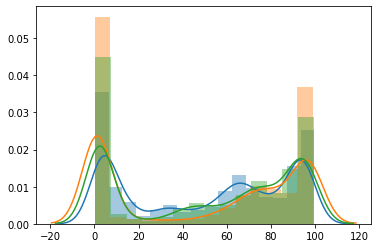

In [64]:
sns.distplot(pred1)
sns.distplot(pred2)
sns.distplot(pred3)
sns.distplot(pred4)
sns.distplot(pred5)

In [67]:
pred = (pred1+pred2+pred3+pred4+pred5)/5

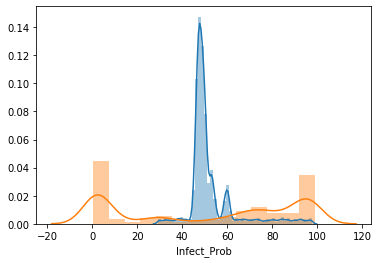

In [68]:
sns.distplot(train['Infect_Prob'])
sns.distplot(pred)

In [69]:
test['Infect_Prob'] = pred
test.to_csv('Prob1_Final_Answer.csv', index=False)